# Network Analysis

This notebook covers the first half of the assessment on network analysis.

In [1]:
# import the necessary libraries
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import re
import shapely
from scipy.spatial import distance

## Construct the topological network

Based on the `tfl_stations.json` and `tfl_lines.json` files, we will create a network of the underground. The code for this part is largely adopted from the practical session.

In [2]:
# load data and project into British National Grid
stations = gpd.read_file(os.path.join('data', 'network', 'tfl_stations.json')).to_crs('EPSG:27700')
lines = gpd.read_file(os.path.join('data', 'network', 'tfl_lines.json')).to_crs('EPSG:27700')

### Edit stations data

In [3]:
# clean station names

# get all names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

# clean the names
for k, v in station_names.items():
    if k == 'none':
        continue
    # get rid of everything other than the name itself - like LU / LO / DLR / ( )
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)

    # combine Bank and Monument as 'Bank and Monument'
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name

# save back into the gdf
stations['name'] = stations['id'].apply(lambda x: station_names[x])

In [4]:
# change position of station to mean of all stations with the same name

pos = {}

for i, station in stations.iterrows():
    # store coordinates
    xy = station.geometry.coords[0]

    # if station already in dictionary, add coordinate to list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    # else add to list and set coordinate as first item in list
    else:
        pos[station['name']] = [xy]

# iterate through the dictionary to replace coordinate with the mean value
for k, v in pos.items():
    pos[k] = np.mean(v, axis = 0)

# set new geometry
stations['geometry'] = stations['name'].apply(lambda x: shapely.Point(pos[x]))

<Axes: >

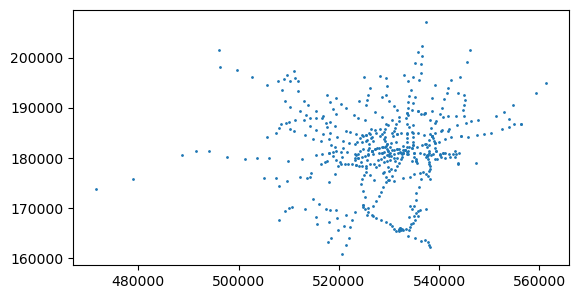

In [5]:
stations.plot(markersize = 1)

### Edit lines data

In [6]:
# get the line names
line_names = lines['lines'].apply(lambda x: [x['name'] for x in json.loads(x)])
line_names = list(set([item for sublist in line_names for item in sublist]))

# Rename the East London Line into the London Overground, as it is part of it
lines['lines'] = lines['lines'].str.replace('East London', 'London Overground')
stations['lines'] = stations['lines'].str.replace('East London', 'London Overground')

# remove the unnecessary lines
remove_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']
for r in remove_lines:
    line_names.remove(r)

line_names


['Hammersmith & City',
 'Waterloo & City',
 'District',
 'Victoria',
 'Metropolitan',
 'Circle',
 'Northern',
 'London Overground',
 'DLR',
 'Central',
 'TfL Rail',
 'Piccadilly',
 'Bakerloo',
 'Jubilee']

In [7]:
# # check the data for each line
# for line in line_names:
#     fig, ax = plt.subplots(figsize = (7,7))
#     fig.suptitle(f'line: {line}')
#     ax.set_aspect("equal")
#     ax.axis('off')
#     ax.margins(0.1)
#     temp_lines = lines[lines.lines.str.contains(line)]
#     base = temp_lines.plot(ax=ax)
#     temp_stations = stations[stations.lines.str.contains(line)]
#     temp_stations.plot(ax=base, markersize=20)
#     plt.show()

### Add geometry

Hammersmith & City


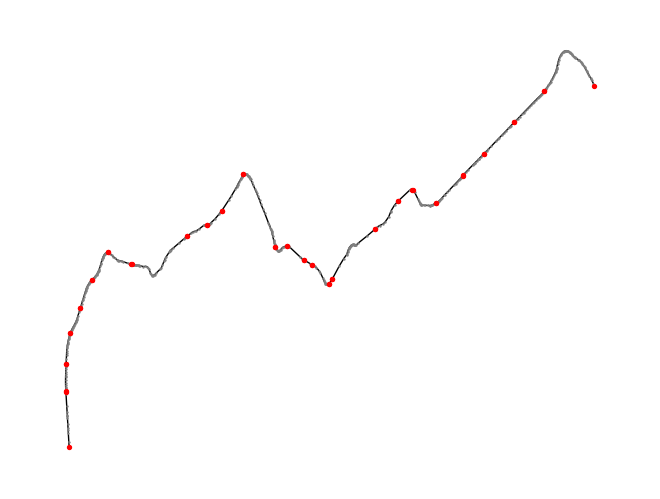

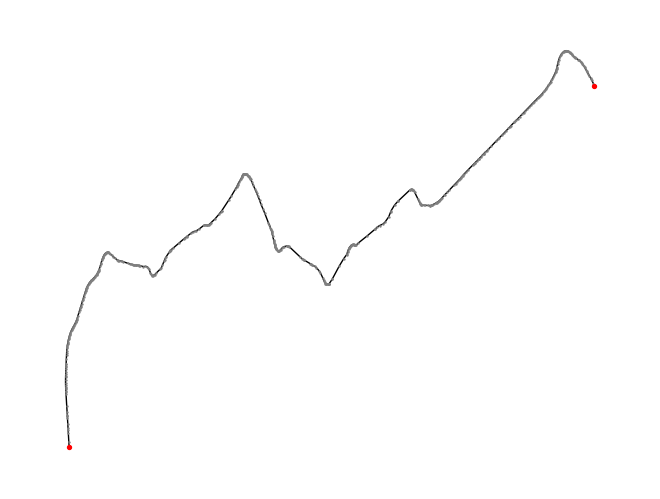

1
Waterloo & City


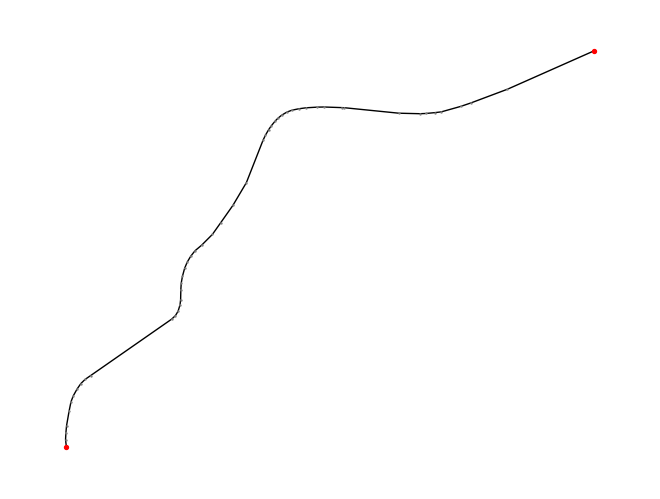

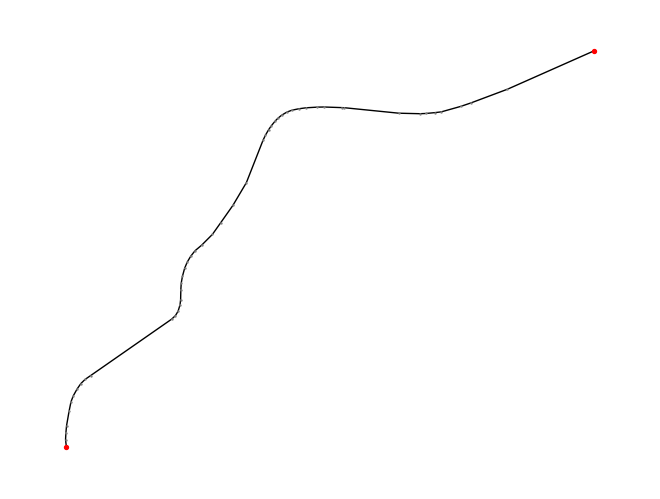

1
District


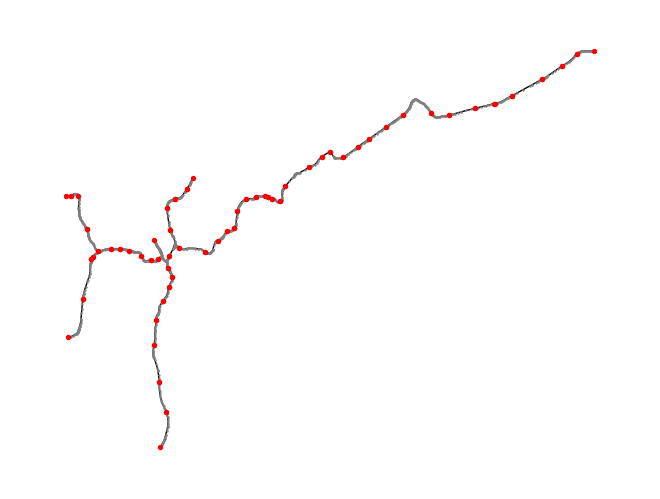

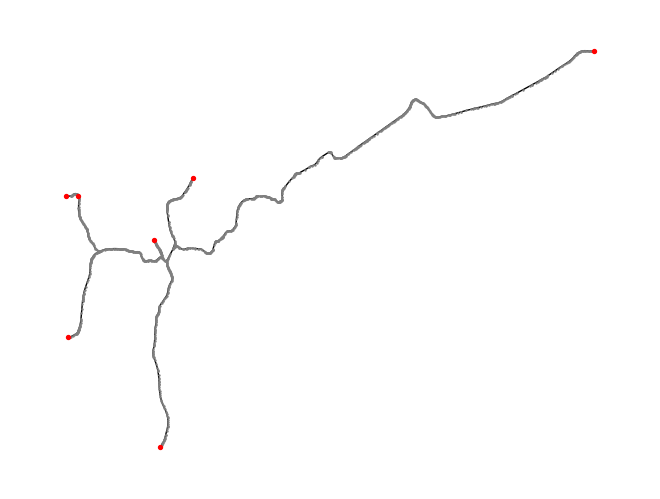

1
Victoria


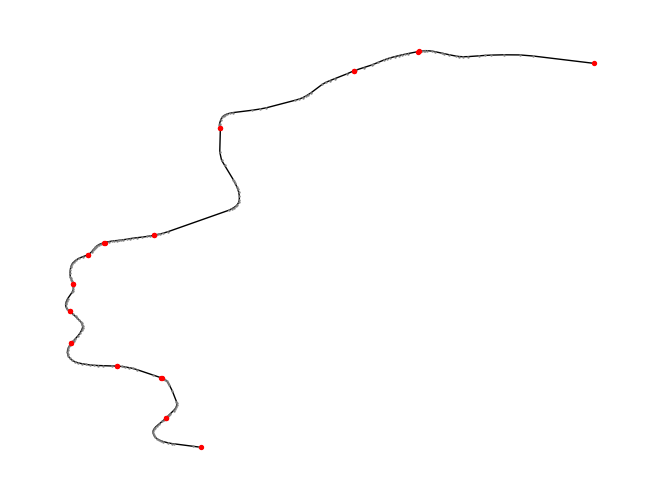

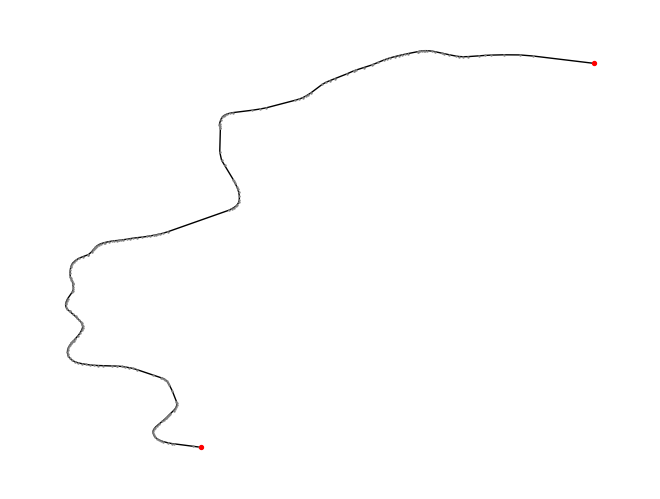

1
Metropolitan


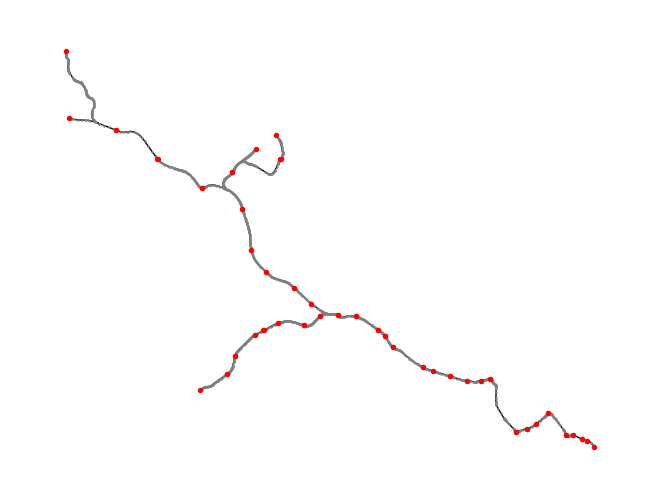

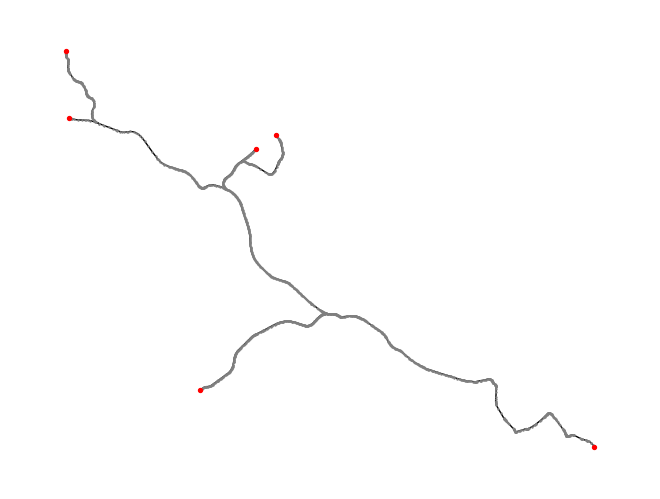

1
Circle


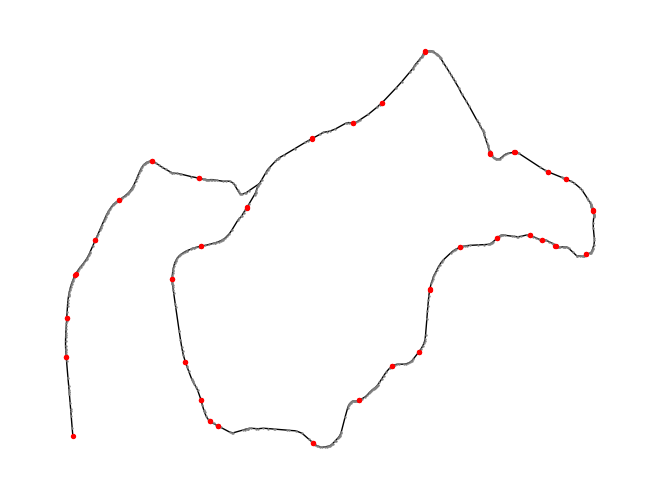

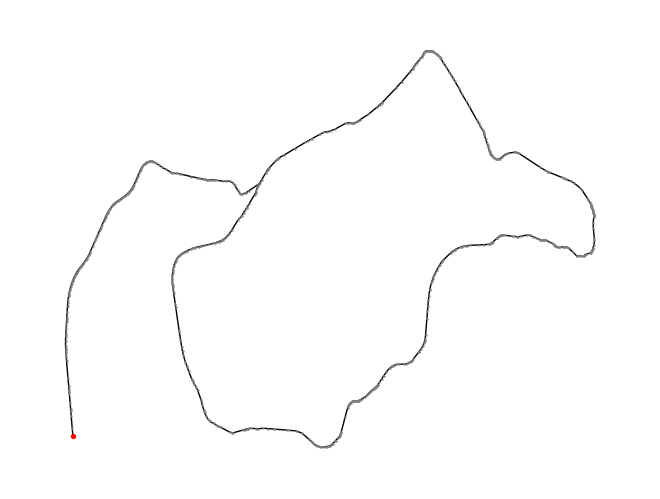

1
Northern


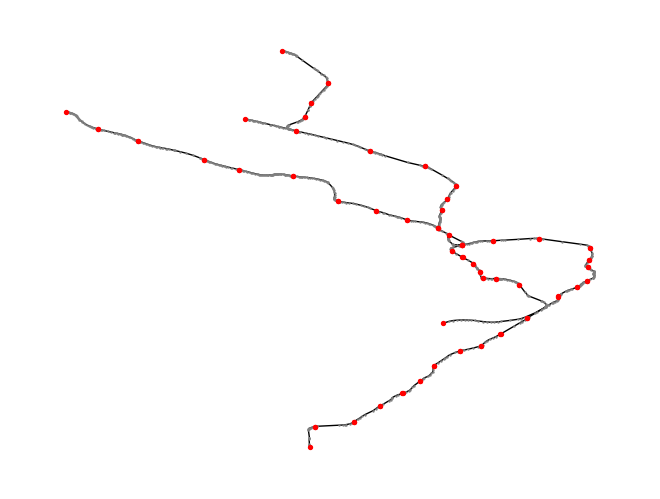

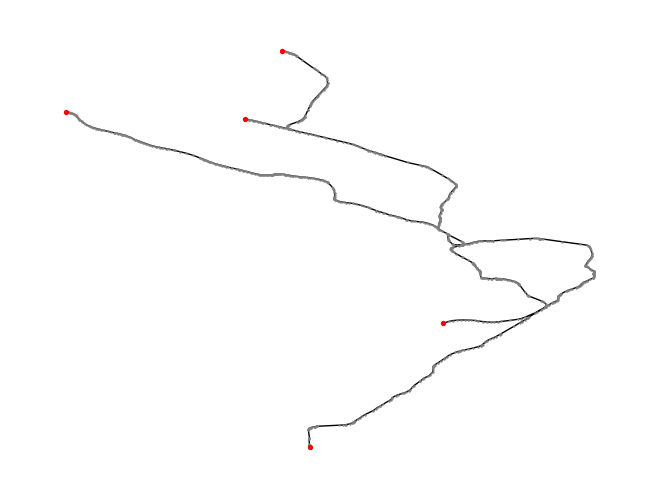

1
London Overground


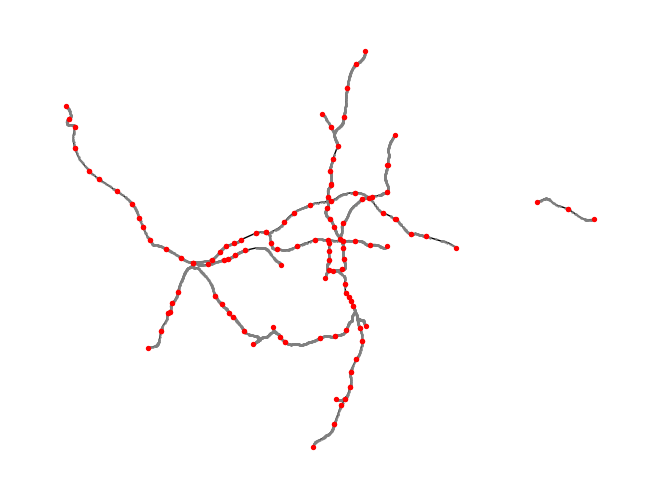

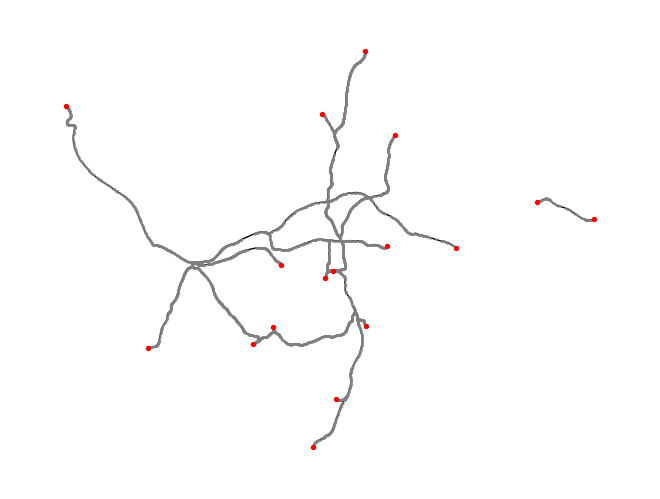

3
DLR


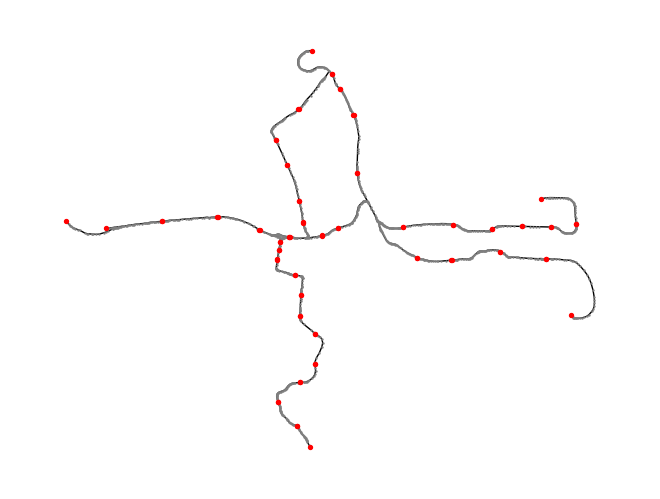

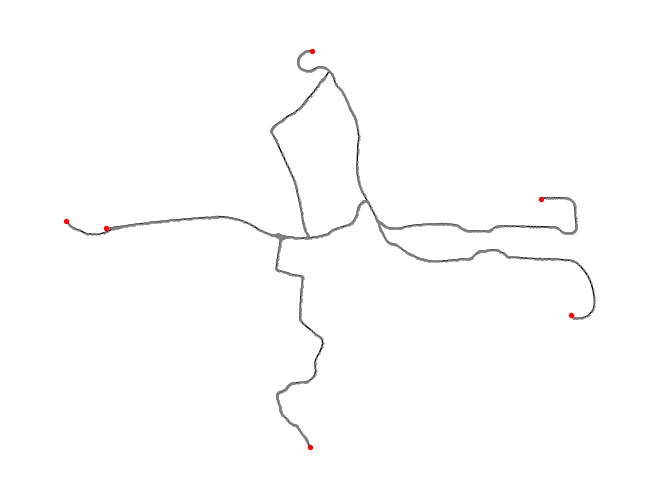

1
Central


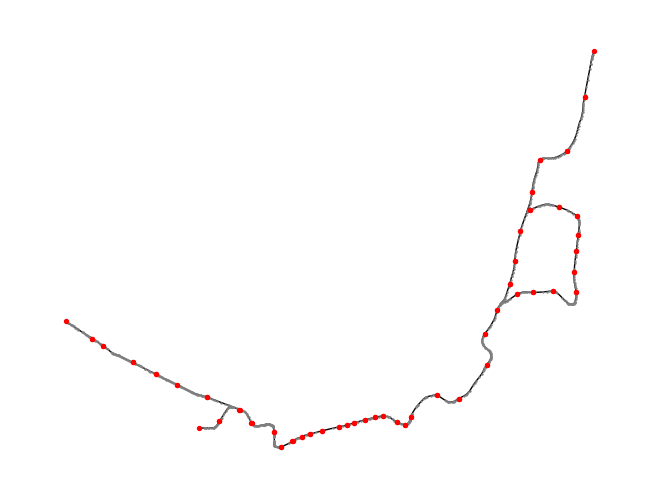

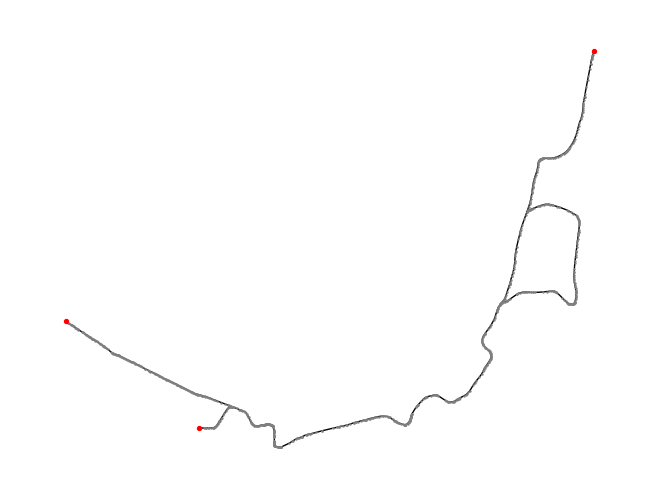

1
TfL Rail


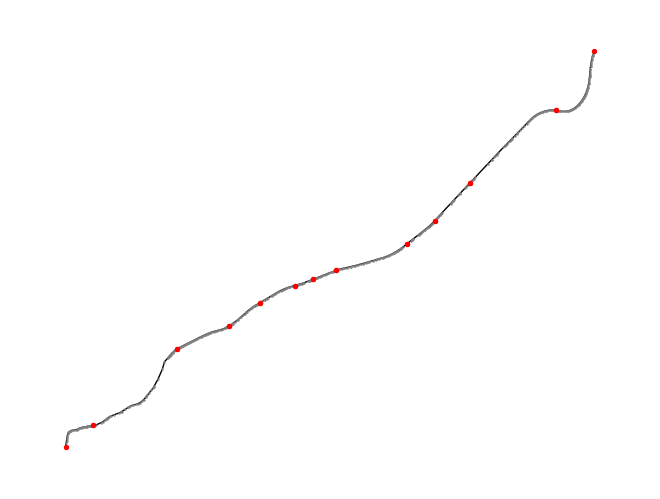

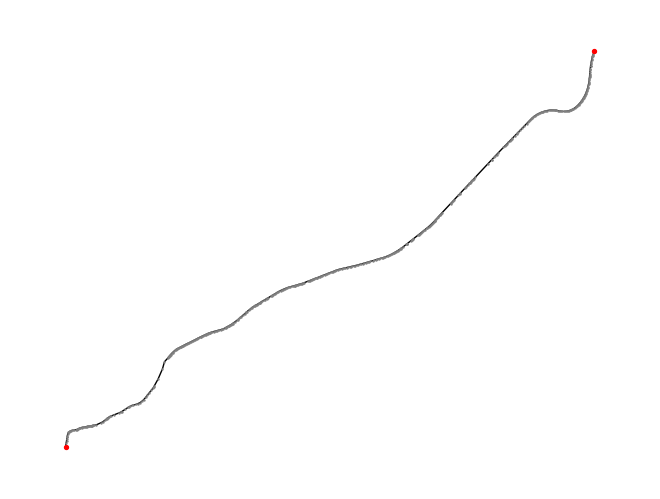

1
Piccadilly


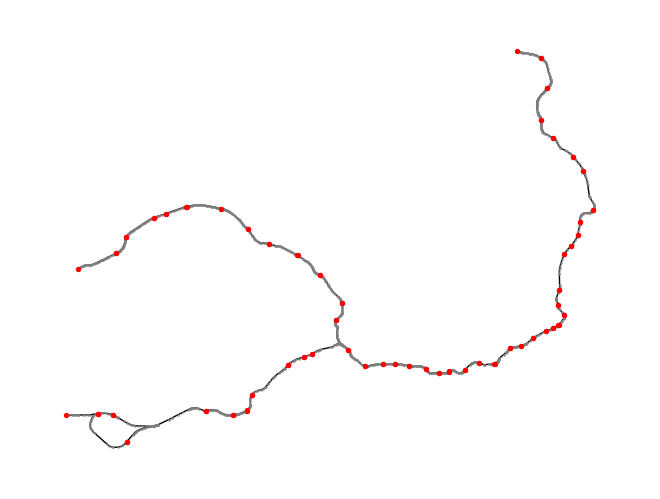

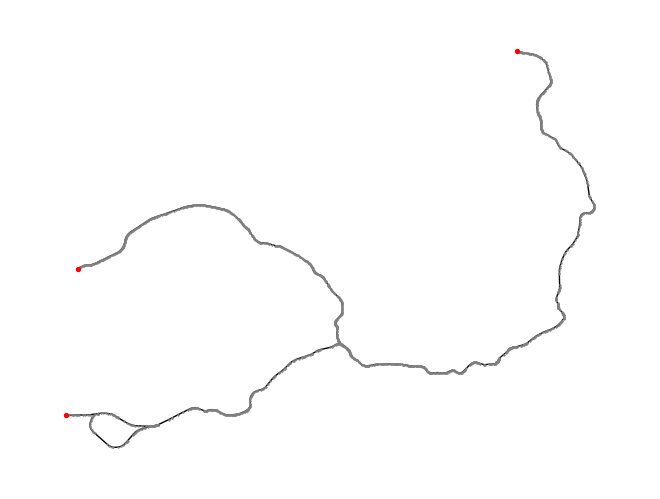

1
Bakerloo


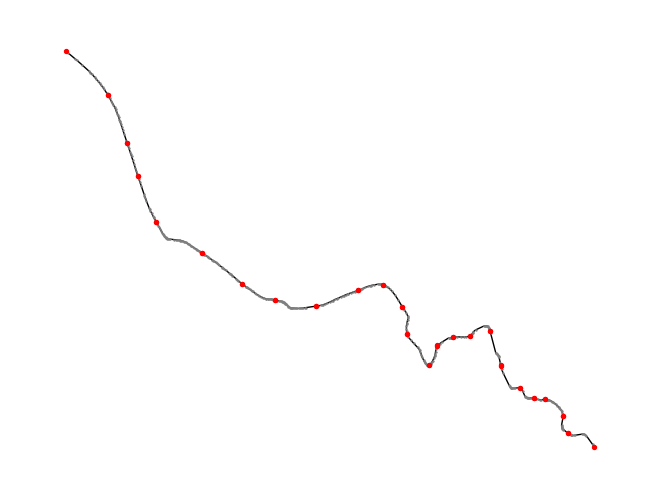

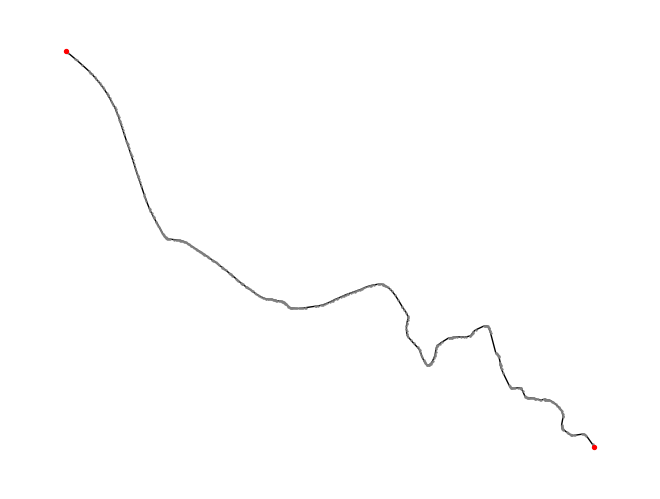

1
Jubilee


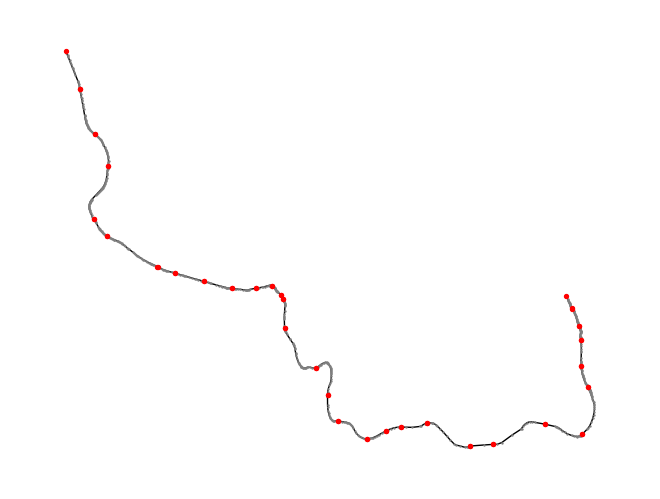

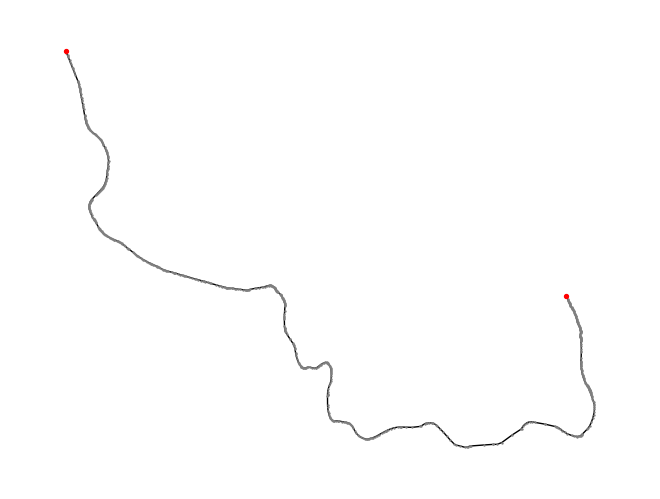

1


In [8]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


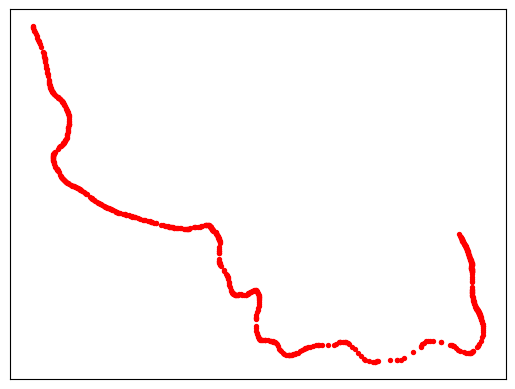

In [9]:
nx.draw_networkx_nodes(G, pos=pos, node_color='red', node_size=8)

In [10]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': shapely.LineString([s_geom, e_geom])
                        })

,line_name,start_id,end_id,geometry
0,Hammersmith & City,940GZZLUADE,940GZZLULVT,"LINESTRING (533885.038 181342.159, 533125.962 ..."
1,Hammersmith & City,940GZZLUADE,940GZZLUWPL,"LINESTRING (533885.038 181342.159, 534615.505 ..."
2,Hammersmith & City,940GZZLUWPL,940GZZLUSGN,"LINESTRING (534615.505 181907.054, 535610.365 ..."
3,Hammersmith & City,940GZZLUSGN,940GZZLUMED,"LINESTRING (535610.365 182118.760, 536520.956 ..."
4,Hammersmith & City,940GZZLUMED,940GZZLUBWR,"LINESTRING (536520.956 182548.396, 537113.179 ..."


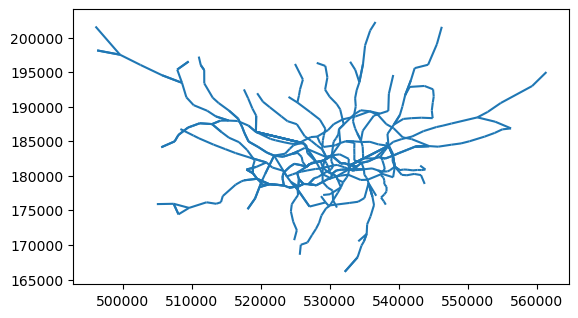

In [11]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

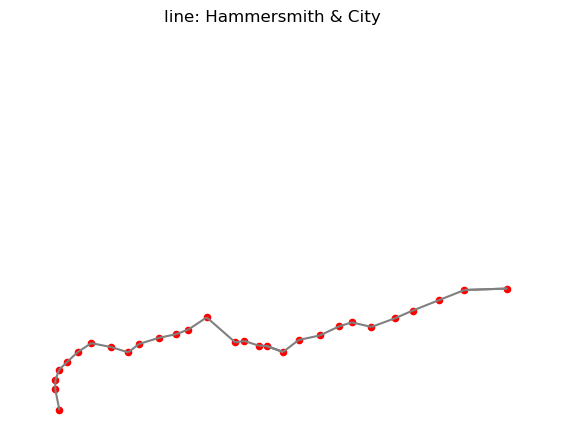

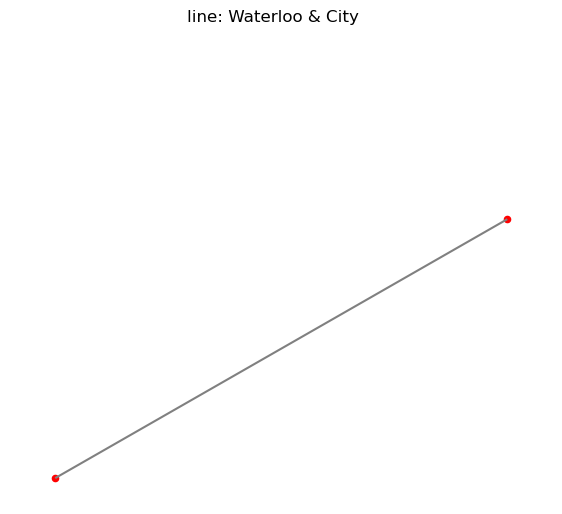

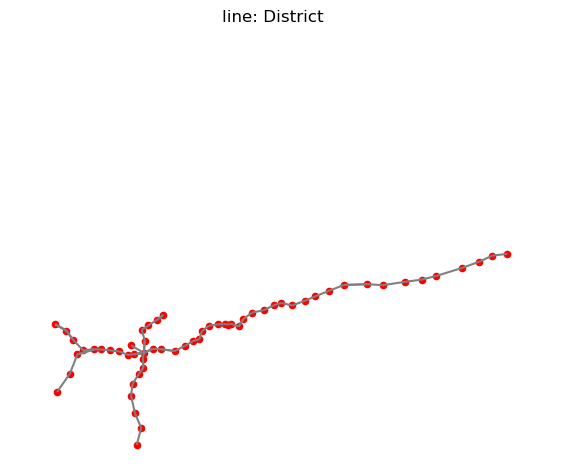

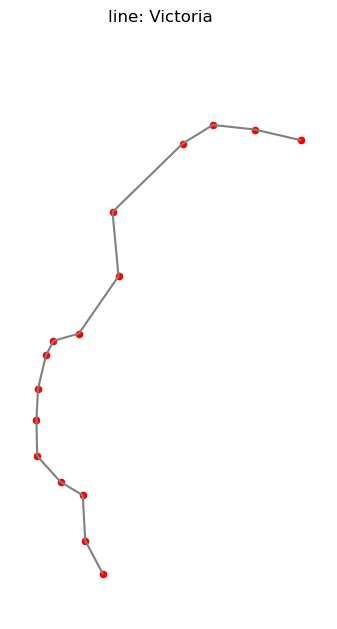

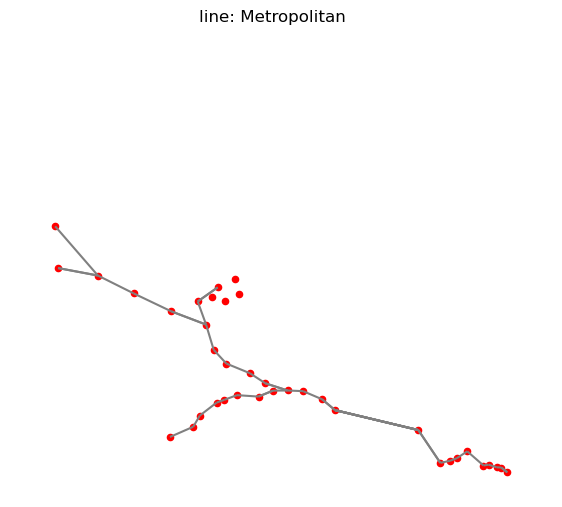

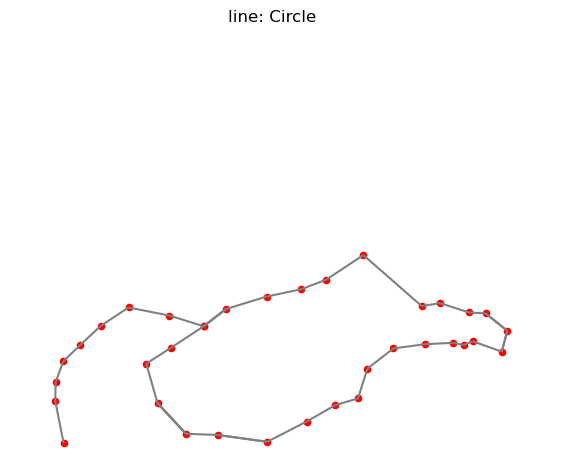

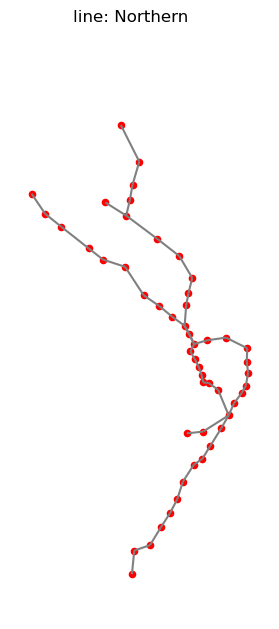

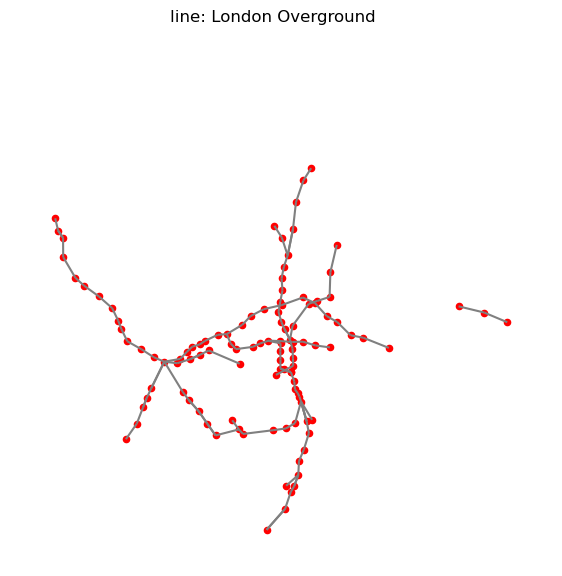

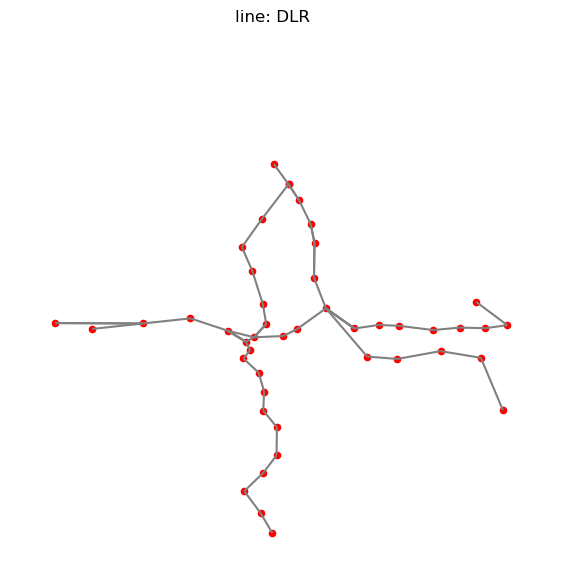

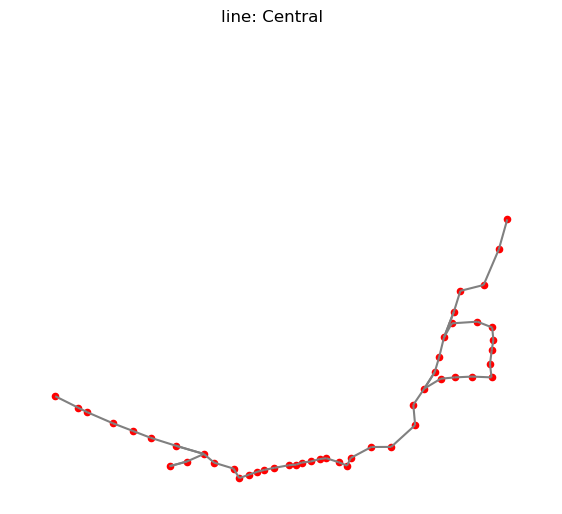

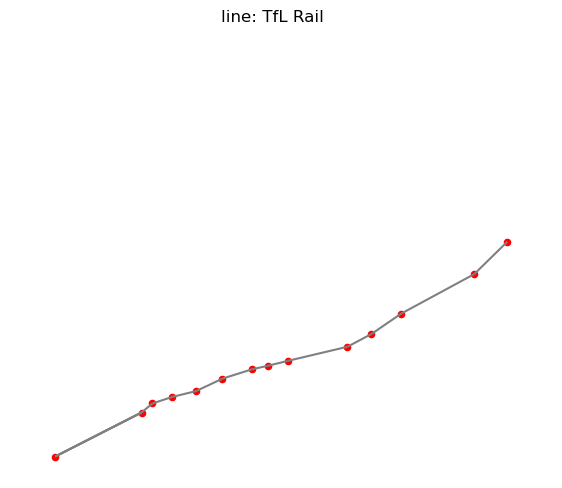

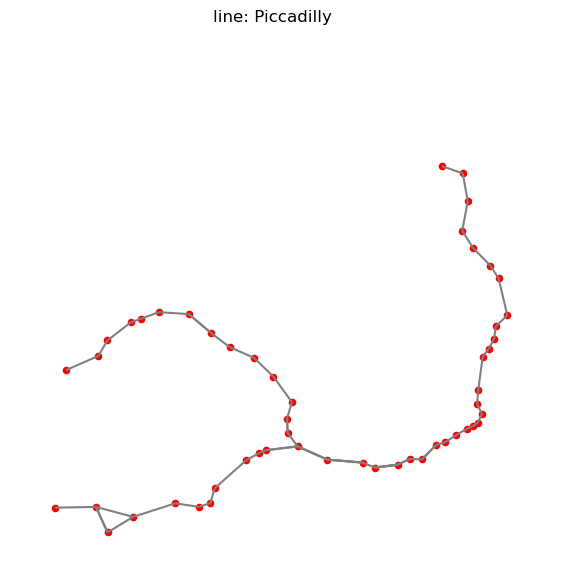

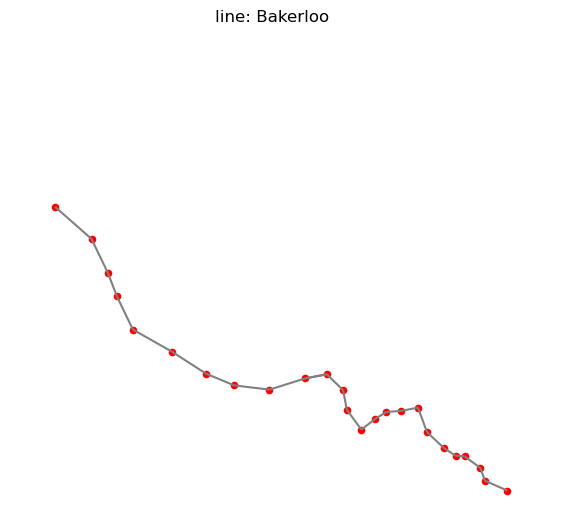

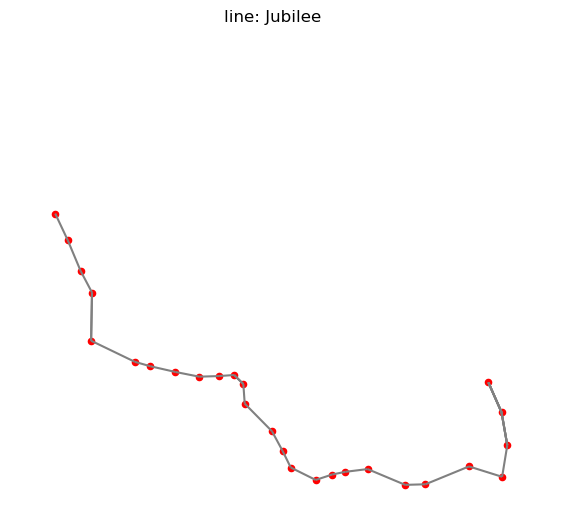

In [12]:
### Add geometry information back into the graph
for line_name in line_names:
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = shapely.LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

### Calculate length and create edge list

,line_name,start_id,end_id,geometry,length
0,Hammersmith & City,940GZZLUADE,940GZZLULVT,"LINESTRING (533885.038 181342.159, 533883.745 ...",965.846291
1,Hammersmith & City,940GZZLUADE,940GZZLUWPL,"LINESTRING (533885.038 181342.159, 533883.745 ...",963.320064
2,Hammersmith & City,940GZZLUWPL,940GZZLUSGN,"LINESTRING (534615.505 181907.054, 534626.544 ...",1080.143048
3,Hammersmith & City,940GZZLUSGN,940GZZLUMED,"LINESTRING (535610.365 182118.760, 535609.027 ...",1029.246974
4,Hammersmith & City,940GZZLUMED,940GZZLUBWR,"LINESTRING (536520.956 182548.396, 536522.286 ...",624.918389


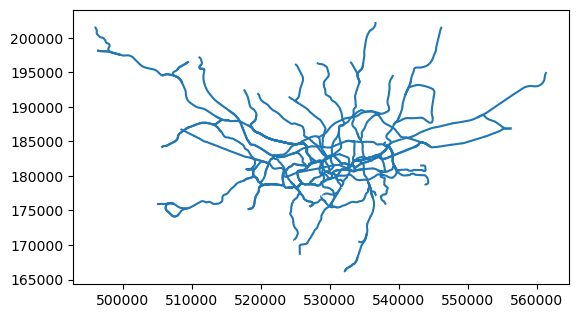

In [13]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

#plot to sanity check
edge_gdf.plot()
edge_gdf.head(5)

In [14]:
#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

### Create Graph

In [15]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'Hammersmith & City', 'Metropolitan', 'Circle', 'Northern', 'London Overground', 'Waterloo & City', 'Piccadilly', 'DLR', 'Bakerloo', 'Central', 'Jubilee', 'District', 'TfL Rail', 'Victoria'}


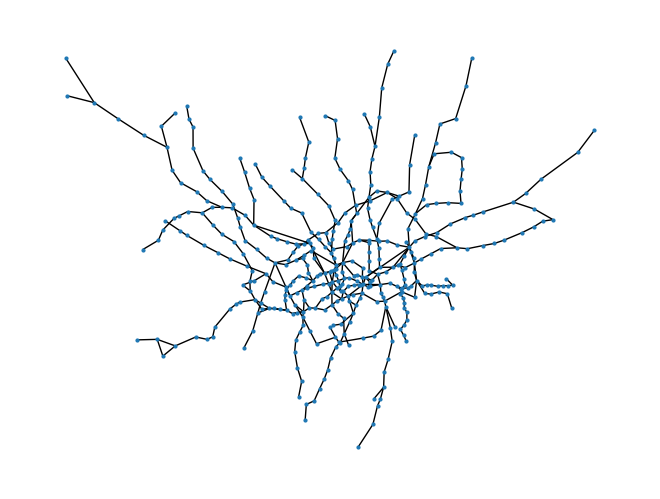

In [16]:
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

The graph will be stored as `G` in a NetworkX format

## Analyse the topological network

Consider the centrality measures of the network we have created.

### Centrality Measures

The following centrality measures are considered:

- degree centrality
- betweenness centrality
- closeness centrality



In [17]:
# calculate degree
degree_london = dict(nx.degree(G))
degree_df = pd.DataFrame.from_dict(degree_london, orient = 'index').rename(columns = {0: 'degree'})
degree_df.sort_values('degree', ascending = False).head(15)

,degree
Stratford,9
Bank and Monument,8
King's Cross St. Pancras,7
Baker Street,7
West Ham,6
Liverpool Street,6
Waterloo,6
Canning Town,6
Earl's Court,6
Oxford Circus,6


In [18]:
# calculate betweenness centrality
between_london = dict(nx.betweenness_centrality(G, weight = 'length', normalized = False))
between_df = pd.DataFrame.from_dict(between_london, orient = 'index').rename(columns = {0: 'betweenness'})
between_df.sort_values('betweenness', ascending = False).head(10)

,betweenness
Bank and Monument,17752.0
King's Cross St. Pancras,16625.0
Stratford,14563.0
Oxford Circus,13515.0
Euston,13218.0
Baker Street,12050.0
Earl's Court,11505.0
Shadwell,11129.0
Waterloo,10420.0
South Kensington,10365.0


In [19]:
# calculate closeness centrality
closeness_london = nx.closeness_centrality(G, distance = 'length')
closeness_df = pd.DataFrame.from_dict(closeness_london, orient = 'index').rename(columns = {0: 'closeness'})

pd.set_option("display.precision", 10)
closeness_df.sort_values('closeness', ascending = False).head(10)

,closeness
Holborn,0.0000792242
King's Cross St. Pancras,0.0000788914
Tottenham Court Road,0.0000788610
Oxford Circus,0.0000787080
Leicester Square,0.0000783327
Piccadilly Circus,0.0000782915
Charing Cross,0.0000782823
Chancery Lane,0.0000782116
Covent Garden,0.0000780522
Embankment,0.0000779722


In [20]:
# set centrality measures as node attributes
nx.set_node_attributes(G, degree_london, 'degree')
nx.set_node_attributes(G, between_london, 'betweenness')
nx.set_node_attributes(G, closeness_london, 'closeness')

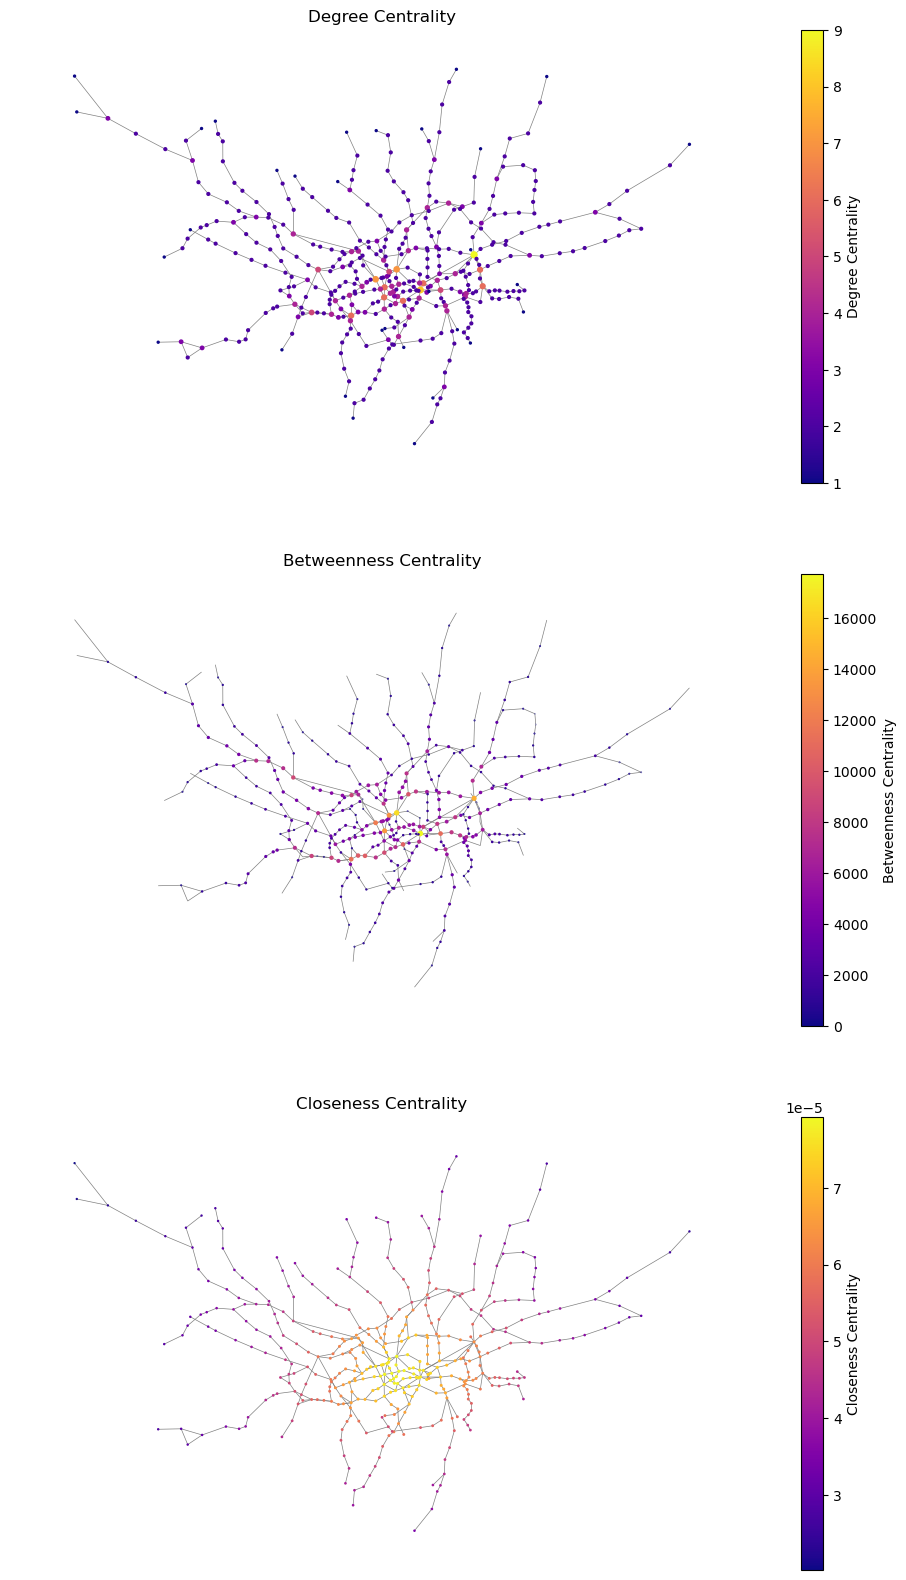

In [21]:
# plot for sanity check

# initalise plot
fig, axes = plt.subplots(3, 1, figsize = (12, 20))

# get position
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}

# draw the network edges for all three as basemap
for ax in axes:
    nx.draw_networkx_edges(G, pos = pos, edge_color = 'gray', width = 0.5, ax = ax)
    ax.axis('off')

# draw degree centrality
degree_plot = nx.draw_networkx_nodes(
    G,
    pos = pos,
    node_color = [c[1]['degree'] for c in G.nodes(data=True)],
    node_size = [c[1]['degree'] * 2 for c in G.nodes(data=True)],
    ax = axes[0],
    cmap = 'plasma'
)

plt.colorbar(
    degree_plot,
    label = 'Degree Centrality',
)

# draw betweenness centrality
between_plot = nx.draw_networkx_nodes(
    G,
    pos = pos,
    node_color = [c[1]['betweenness'] for c in G.nodes(data=True)],
    node_size = [c[1]['betweenness'] / 2000 for c in G.nodes(data=True)],
    ax = axes[1],
    cmap = 'plasma'
)

plt.colorbar(
    between_plot,
    label = 'Betweenness Centrality',
)

# draw closeness centrality
closeness_plot = nx.draw_networkx_nodes(
    G,
    pos = pos,
    node_color = [c[1]['closeness'] for c in G.nodes(data=True)],
    node_size = [c[1]['closeness'] * 20000 for c in G.nodes(data=True)],
    ax = axes[2],
    cmap = 'plasma'
)

plt.colorbar(
    closeness_plot,
    label = 'Closeness Centrality',
)

# set title
axes[0].set_title('Degree Centrality')
axes[1].set_title('Betweenness Centrality')
axes[2].set_title('Closeness Centrality')

plt.show()

### Network performance measures

The following network performance measures are considered:

- average shortest path length
- number of loops


In [22]:
# measures 
nx.average_shortest_path_length(G)

13.545997506234414

In [23]:
nx.global_efficiency(G)

0.10125619359721788

In [24]:
# get the stations to remove
degree_list = degree_df.sort_values('degree', ascending = False).index.to_list()
between_list = between_df.sort_values('betweenness', ascending = False).index.to_list()
closeness_list = closeness_df.sort_values('closeness', ascending = False).index.to_list()

# make into dictionary
station_lists = {
    'degree': degree_list, 
    'betweenness': between_list,
    'closeness': closeness_list
}

# create graph for non-sequential removal
nonseq_removal = {
    'degree': [G.copy()],
    'betweenness': [G.copy()],
    'closeness': [G.copy()]
}

for key in station_lists:
    print(f'Consider {key} centrality')
    for i in np.arange(10):
        G_temp =  nonseq_removal[key][i].copy()
        print(f'{i}: Removing {station_lists[key][i]}')
        G_temp.remove_node(station_lists[key][i])
        nonseq_removal[key].append(G_temp)

Consider degree centrality
0: Removing Stratford
1: Removing Bank and Monument
2: Removing King's Cross St. Pancras
3: Removing Baker Street
4: Removing West Ham
5: Removing Liverpool Street
6: Removing Waterloo
7: Removing Canning Town
8: Removing Earl's Court
9: Removing Oxford Circus
Consider betweenness centrality
0: Removing Bank and Monument
1: Removing King's Cross St. Pancras
2: Removing Stratford
3: Removing Oxford Circus
4: Removing Euston
5: Removing Baker Street
6: Removing Earl's Court
7: Removing Shadwell
8: Removing Waterloo
9: Removing South Kensington
Consider closeness centrality
0: Removing Holborn
1: Removing King's Cross St. Pancras
2: Removing Tottenham Court Road
3: Removing Oxford Circus
4: Removing Leicester Square
5: Removing Piccadilly Circus
6: Removing Charing Cross
7: Removing Chancery Lane
8: Removing Covent Garden
9: Removing Embankment


In [25]:
# sequential removal

# create station lists
seq_station_lists = {
    'degree': [], 
    'betweenness': [],
    'closeness': []
}

# create graph for non-sequential removal
seq_removal = {
    'degree': [G.copy()],
    'betweenness': [G.copy()],
    'closeness': [G.copy()]
}

# degree centrality
print('Degree Centrality')
for i in np.arange(10):
    G_temp = seq_removal['degree'][i].copy()

    # calculate the node to remove - the one with the highest degree centrality
    removing_node = sorted(nx.degree(G_temp), key = lambda x: x[1], reverse = True)[0][0]
    seq_station_lists['degree'].append(removing_node)
    # remove node from graph
    print(f'{i}: Removing {removing_node}')
    G_temp.remove_node(removing_node)
    # add to list
    seq_removal['degree'].append(G_temp)

# betweenness centrality
print('Betweenness Centrality')
for i in np.arange(10):
    G_temp = seq_removal['betweenness'][i].copy()

    # calculate the node to remove - the one with the highest betweenness centrality
    removing_node = sorted(nx.betweenness_centrality(G_temp, weight = 'length').items(), key = lambda x: x[1], reverse = True)[0][0]
    seq_station_lists['betweenness'].append(removing_node)
    # remove node from graph
    print(f'{i}: Removing {removing_node}')
    G_temp.remove_node(removing_node)
    # add to list
    seq_removal['betweenness'].append(G_temp)

# closeness centrality
print('Closeness Centrality')
for i in np.arange(10):
    G_temp = seq_removal['closeness'][i].copy()

    # calculate the node to remove - the one with the highest closeness centrality
    removing_node = sorted(nx.closeness_centrality(G_temp, distance = 'length').items(), key = lambda x: x[1], reverse = True)[0][0]
    seq_station_lists['closeness'].append(removing_node)
    # remove node from graph
    print(f'{i}: Removing {removing_node}')
    G_temp.remove_node(removing_node)
    # add to list
    seq_removal['closeness'].append(G_temp)


Degree Centrality
0: Removing Stratford
1: Removing Bank and Monument
2: Removing Baker Street
3: Removing King's Cross St. Pancras
4: Removing Earl's Court
5: Removing Green Park
6: Removing Canning Town
7: Removing Waterloo
8: Removing Turnham Green
9: Removing Oxford Circus
Betweenness Centrality


0: Removing Bank and Monument
1: Removing King's Cross St. Pancras
2: Removing Canada Water
3: Removing West Hampstead
4: Removing Earl's Court
5: Removing Oxford Circus
6: Removing Shepherd's Bush
7: Removing Baker Street
8: Removing Acton Town
9: Removing Stratford
Closeness Centrality
0: Removing Holborn
1: Removing King's Cross St. Pancras
2: Removing Embankment
3: Removing Waterloo
4: Removing London Bridge
5: Removing West Hampstead
6: Removing Clapham Junction
7: Removing Mile End
8: Removing Stratford
9: Removing Oxford Circus


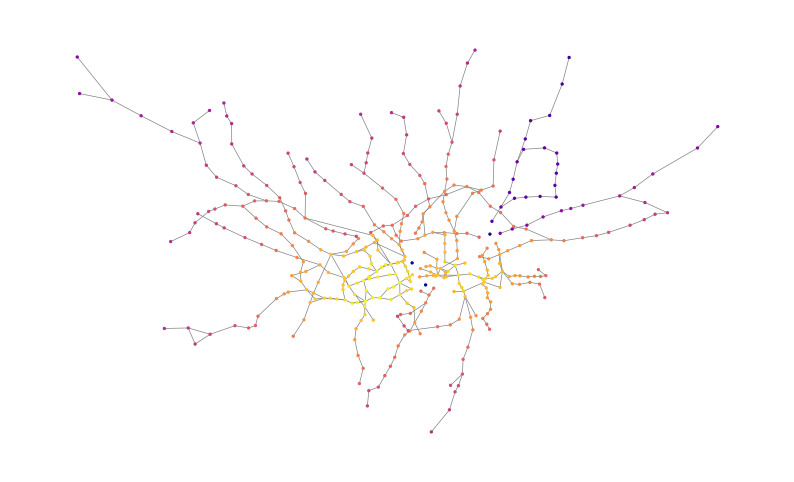

In [26]:
# sanity check closeness centrality

G_number = 10

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
nx.draw_networkx_edges(seq_removal['closeness'][G_number], pos = pos, edge_color = 'gray', width = 0.5, ax = ax)
ax.axis('off')

nx.draw_networkx_nodes(
    seq_removal['closeness'][G_number],
    pos = pos,
    node_color = list(nx.closeness_centrality(seq_removal['closeness'][G_number], distance = 'length').values()),
    node_size = 2,
    ax = ax,
    cmap = 'plasma'
)

In [27]:
# define global efficiency considering weight 
def global_efficiency_weighted(G, weight=None):
    n = len(G)
    denom = n * (n - 1)
    g_eff = 0
    if denom != 0:
        # calculate distance for all pairs, considering the distance

        all_shortest_paths = dict(nx.all_pairs_dijkstra_path_length(G, weight=weight))
        for source in all_shortest_paths:
            for target, distance in all_shortest_paths[source].items():
                if distance > 0:
                    g_eff += 1 / distance

        g_eff /= denom    
    return g_eff

print(global_efficiency_weighted(G))
print(nx.global_efficiency(G))


0.10125619359721788
0.10125619359721788


In [28]:
# calculate the measures
nonseq_measures = pd.DataFrame(nonseq_removal)
seq_measures = pd.DataFrame(seq_removal)

for df in [nonseq_measures, seq_measures]:
    for c in df.columns.to_list():
        df[f'{c}_ncc'] = df.apply(lambda x: nx.number_connected_components(x[c]), axis = 1)
        df[f'{c}_lcc'] = df.apply(lambda x: [len(c) for c in sorted(nx.connected_components(x[c]), key = len, reverse = True)][0], axis = 1)
        df[f'{c}_ave_length'] = df.apply(
            lambda x: (nx.average_shortest_path_length(x[c]) if nx.number_connected_components(x[c]) == 1 else np.nan), axis = 1
        )
        df[f'{c}_efficiency'] = df.apply(
            lambda x: global_efficiency_weighted(x[c], weight = 'length'),
            axis = 1
        )


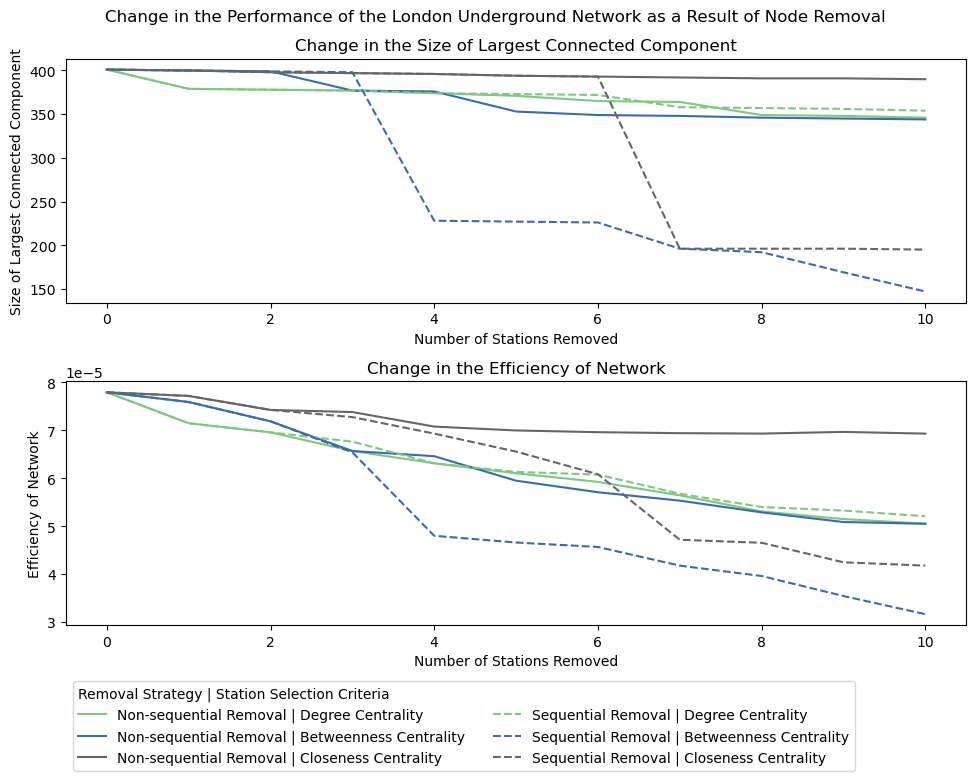

In [29]:
# plot change in largest connecting component

# initialise plot
fig, axes = plt.subplots(2, 1, figsize = (10, 8))

# set color map
color_palette = 'Accent'


# ----- Plot Largest Connected Component -----

# plot sequential removal

# plot nonsequential removal
nonseq_measures.plot(
    y = ['degree_lcc', 'betweenness_lcc', 'closeness_lcc'],
    ax = axes[0],
    cmap = color_palette,
    legend = False
)
seq_measures.plot(
    y = ['degree_lcc', 'betweenness_lcc', 'closeness_lcc'],
    ax = axes[0],
    style = '--',
    cmap = color_palette,
    legend = False
)

# set axis labels
axes[0].set_xlabel('Number of Stations Removed')
axes[0].set_ylabel('Size of Largest Connected Component')
axes[0].set_title('Change in the Size of Largest Connected Component')

# ----- Plot Efficiency -----

# plot sequential removal
# plot non-sequential removal
nonseq_measures.plot(
    y = ['degree_efficiency', 'betweenness_efficiency', 'closeness_efficiency'],
    ax = axes[1],
    cmap = color_palette,
    label = ['Non-sequential Removal | Degree Centrality', 'Non-sequential Removal | Betweenness Centrality', 'Non-sequential Removal | Closeness Centrality']
)

seq_measures.plot(
    y = ['degree_efficiency', 'betweenness_efficiency', 'closeness_efficiency'],
    ax = axes[1],
    style = '--',
    cmap = color_palette,
    label = ['Sequential Removal | Degree Centrality', 'Sequential Removal | Betweenness Centrality', 'Sequential Removal | Closeness Centrality']
)

# set axis labels
axes[1].set_xlabel('Number of Stations Removed')
axes[1].set_ylabel('Efficiency of Network')
axes[1].set_title('Change in the Efficiency of Network')

# set legend
axes[1].legend(
    title = 'Removal Strategy | Station Selection Criteria', 
    ncols = 2, alignment = 'left',
    loc = 'upper left', bbox_to_anchor = (0, -0.2)
)

# set title
plt.suptitle('Change in the Performance of the London Underground Network as a Result of Node Removal')

# tight layout
plt.tight_layout()

# show plot
# plt.show()
plt.savefig('documents/img/node_removal_measures.png', bbox_inches = 'tight')

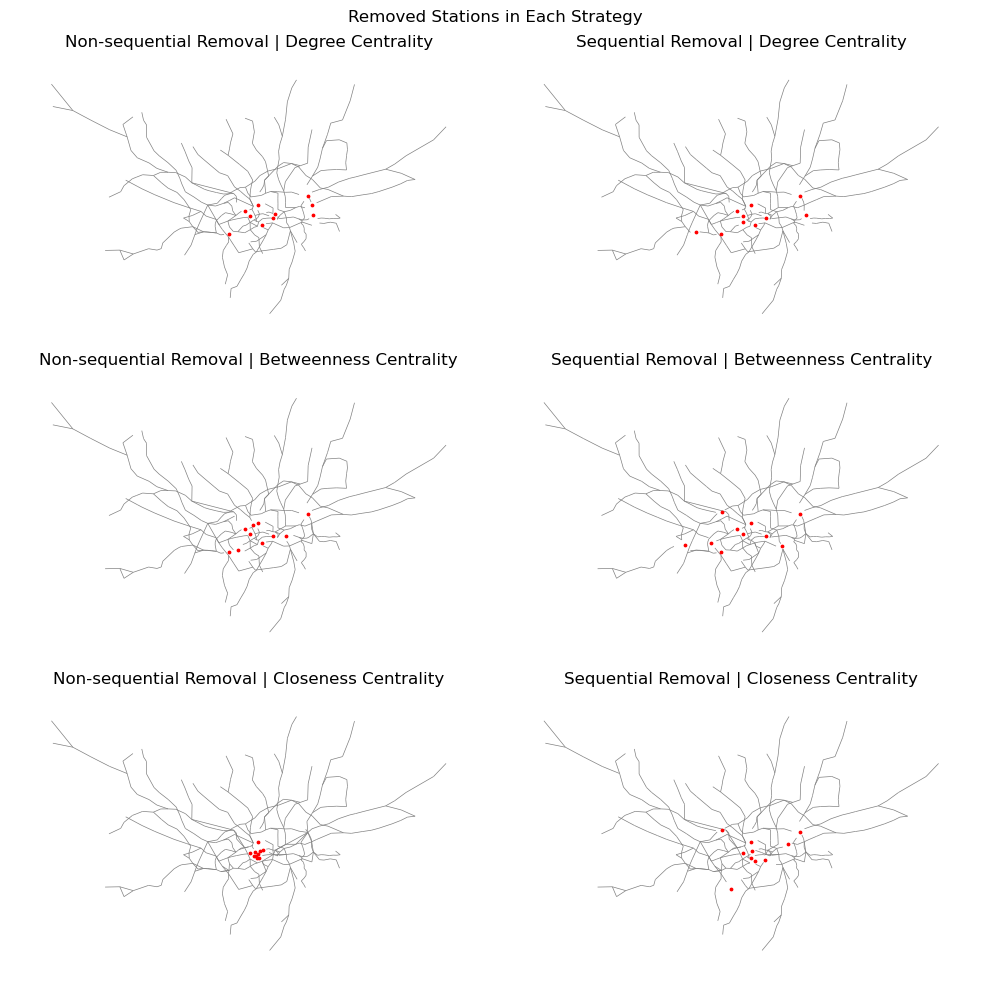

In [30]:
# plot the outcome graph

# plot for sanity check

# initalise plot
fig, axes = plt.subplots(3, 2, figsize = (10, 10))

centrality_measures = ['degree', 'betweenness', 'closeness']
dfs = [nonseq_measures, seq_measures]

# draw the graphs
# the 3 rows refer to centrality measures
# the 2 colomns refer to the strategy
for i, rows in enumerate(axes):
    for j, ax in enumerate(rows):
        # network in question
        G_temp = dfs[j][centrality_measures[i]][10]
        # draw the network edges for all three as basemap
        nx.draw_networkx_edges(G_temp, pos = pos, edge_color = 'gray', width = 0.5, ax = ax)
        ax.axis('off')

        # draw all nodes
        removed_nodes_plot = nx.draw_networkx_nodes(
            G,
            pos = pos,
            nodelist = [n for n in list(G) if n not in list(G_temp)],
            node_color = 'red',
            node_size = 3,
            ax = ax,
        )

        # set title
        ax.set_title(f"{'Non-s' if j == 0 else 'S'}equential Removal | {centrality_measures[i].capitalize()} Centrality")

# plot title
plt.suptitle('Removed Stations in Each Strategy')

# tight layout
plt.tight_layout()

# plot figure
# plt.show()
plt.savefig('documents/img/node_removal_results.png')

## Merge with Flow data

Now that we have finished the topological network, consider the OD flows to generate the flow of networks.

### Load flow data

First we will load the flow data

In [31]:
# create a list of all the different files we need
OD_files = ['NBT19MTT2b_od__DLR_tb_wf.csv', 
         'NBT19MTT2b_od__EZL_tb_wf.csv', 
         'NBT19MTT2b_od__LO_tb_wf.csv', 
         'NBT19MTT2b_od__LU_tb_wf.csv']

# create an empty list to store dataframes for each file
dfs = []

# iterate through our files list, read the file and append to our dataframe list
for file in OD_files:
    dfs.append(pd.read_csv('data/network/' + file))
    
# merge all dataframes
london_OD = pd.concat(dfs, ignore_index=True)

# take a look at our data
london_OD.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8
0,504,523,8.033,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN
1,504,533,30.719,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN
2,504,538,5.941,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN
3,504,559,5.795,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN
4,504,573,77.786,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN


In [32]:
# load definitions file
definition_df = pd.read_excel('data/network/NBT19_Definitions.xlsx', 'Stations')

# drop NA values
definition_df.dropna(inplace = True)

# transform MNLC to int
definition_df['MNLC'] = definition_df['MNLC'].astype(int)

definition_df.head(5)

,MNLC,MASC,StationName,TFL?
0,500,ACTu,Acton Town,True
1,501,BARu,Barbican,True
2,502,ALDu,Aldgate,True
3,503,ALEu,Aldgate East,True
4,504,STId,Stratford International DLR,True


In [33]:
# merge the station names 
london_OD = london_OD.merge(
    definition_df[['MNLC', 'StationName']],
    how = 'left',
    left_on = 'mode_mnlc_o',
    right_on = 'MNLC'
).drop(columns = ['MNLC']).rename(columns = {'StationName': 'station_origin'}).merge(
    definition_df[['MNLC', 'StationName']],
    how = 'left',
    left_on = 'mode_mnlc_d',
    right_on = 'MNLC'
).drop(columns = ['MNLC']).rename(columns = {'StationName': 'station_destination'})


In [34]:
# only keep the flows we need
london_OD_AMpeak = london_OD[['station_origin', 'station_destination', '3']].copy().rename({'3':'flows'}, axis = 1)


In [35]:
# clean station names that have different annotations
london_OD_AMpeak['station_origin']= london_OD_AMpeak.station_origin.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )
london_OD_AMpeak['station_destination']=london_OD_AMpeak.station_destination.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )

# group by origin and destination station and sum the flows
london_OD_AMpeak = london_OD_AMpeak.groupby(['station_origin', 'station_destination'], as_index=False).sum()

In [36]:
london_OD_AMpeak.head()

,station_origin,station_destination,flows
0,Abbey Road,Bank and Monument,0.022
1,Abbey Road,Beckton,1.586
2,Abbey Road,Blackwall,3.522
3,Abbey Road,Canary Wharf,1.143
4,Abbey Road,Canning Town,37.389


### Merge the datasets

In [37]:
# look for differences in the names
OD_names = set(london_OD_AMpeak.station_origin.unique())
network_names = set([n for n in G.nodes()])

network_names.symmetric_difference(OD_names)

{'Acton Main Line',
 'Battersea Power Station',
 'Hanwell',
 'Hayes & Harlington',
 'Heathrow Terminal 4 EL',
 'Heathrow Terminals 123',
 'Heathrow Terminals 2 & 3',
 'Heathrow Terminals 2 & 3 EL',
 'Nine Elms',
 'Southall',
 "Walthamstow Queen's Road",
 'Walthamstow Queens Road',
 'West Ealing'}

In [38]:
# get the names we need to fix
name_map = {
    'Heathrow Terminal 4 EL': 'Heathrow Terminal 4',
    'Heathrow Terminals 123': 'Heathrow Terminals 2 & 3',
    'Heathrow Terminals 2 & 3 EL': 'Heathrow Terminals 2 & 3',
    "Walthamstow Queen's Road": 'Walthamstow Queens Road'
}

# apply to the OD dataframe
london_OD_AMpeak.station_origin = london_OD_AMpeak.station_origin.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)
london_OD_AMpeak.station_destination = london_OD_AMpeak.station_destination.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)

In [39]:
# filter stations we don't need

# get the names we don't need
OD_names = set(london_OD_AMpeak.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))

# filter from data frame
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_origin.isin(_filter)]
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_destination.isin(_filter)]

In [40]:
# calculate flow per segment and add back to network

#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

# calculate shortest paths for all flows and add data to dict
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target, weight = 'length')
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

In [41]:
# get the inverse flow
inverse_flows = flows.copy()

for k in inverse_flows:
    try:
        inverse_flows[k] = 1 / inverse_flows[k]
    except: 
        inverse_flows[k] = np.inf

#set this as a network attribute
nx.set_edge_attributes(G, inverse_flows, 'inv_flows')


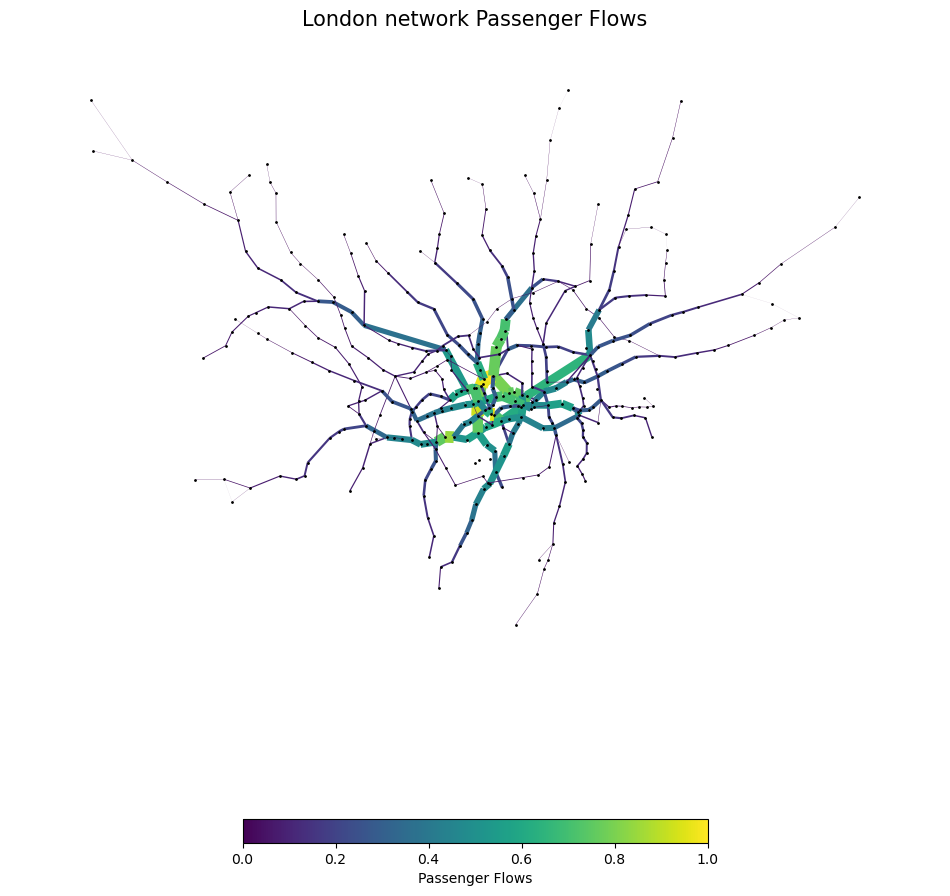

In [42]:
# plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

In [43]:
# # save graph
# nx.write_graphml_lxml(G, "data/network/london_updated.graph")

## Analysis on the new network

Using the network we have just defined, consider the centrality measures newly defined.

In [44]:
# calculate weighted degree centrality
weighted_centrality = pd.DataFrame(nx.degree(G, weight = 'flows')).sort_values(by = 1, ascending = False).rename(columns = {0 : 'station_name', 1: 'degree'})

weighted_centrality.sort_values('degree', ascending = False).head(10)

,station_name,degree
30,Bank and Monument,521071.6760863388
81,Oxford Circus,501179.4439798377
15,King's Cross St. Pancras,465519.2109715687
29,Waterloo,335578.5391856006
83,Euston,328639.3347597166
12,Baker Street,320691.3010312130
80,Green Park,314078.9239165218
58,Victoria,295590.3409457707
1,Liverpool Street,276959.0161138350
61,Embankment,253408.3020670451


In [45]:
# calculate betweenness_centrality

# create df of starting and ending journeys
OD_temp = pd.DataFrame(london_OD_AMpeak.groupby('station_origin')['flows'].sum()).rename(columns = {'flows': 'O_i'}).merge(
    pd.DataFrame(london_OD_AMpeak.groupby('station_destination')['flows'].sum()).rename(columns = {'flows': 'D_j'}),
    left_index = True,
    right_index = True
)

# merge with self-loops
OD_temp = OD_temp.merge(
    london_OD_AMpeak[london_OD_AMpeak['station_origin'] == london_OD_AMpeak['station_destination']].rename(columns = {'flows': 'T_ii'}).iloc[:, 1:],
    how = 'left',
    left_index = True,
    right_on = 'station_destination'
).set_index('station_destination').fillna(0)


In [46]:
weighted_centrality = weighted_centrality.merge(
    OD_temp,
    how = 'left',
    left_on = 'station_name',
    right_index = True
)

weighted_centrality['betweenness'] = weighted_centrality['degree'] - (weighted_centrality['O_i'] + weighted_centrality['D_j'] - weighted_centrality['T_ii'])

weighted_centrality[['station_name', 'degree', 'betweenness']].sort_values('betweenness', ascending = False).head(10)

,station_name,degree,betweenness
81,Oxford Circus,501179.4439798377,453770.7419567657
30,Bank and Monument,521071.6760863388,412739.6860983348
15,King's Cross St. Pancras,465519.2109715687,403611.8340703867
12,Baker Street,320691.3010312130,298037.5540395520
83,Euston,328639.3347597166,293783.1917491296
80,Green Park,314078.9239165218,285019.7418793128
29,Waterloo,335578.5391856006,244528.1682068976
61,Embankment,253408.3020670451,238853.1260082741
144,Charing Cross,241003.2060336080,227243.3840449580
58,Victoria,295590.3409457707,224567.0170529977


In [47]:
# calculate harmonic centrality
pd.DataFrame.from_dict(nx.harmonic_centrality(G, distance = 'inv_flows'), orient = 'index').sort_values(by = 0, ascending = False).head(10)

,0
Oxford Circus,3.1198124369e+06
Bank and Monument,3.0257108091e+06
King's Cross St. Pancras,2.9831557623e+06
Euston,2.9605655527e+06
Warren Street,2.9335451959e+06
Green Park,2.8861837800e+06
Waterloo,2.8378427421e+06
Victoria,2.7705240721e+06
Farringdon,2.7458636857e+06
Liverpool Street,2.7185837781e+06


In [87]:
# remove nodes according to highest betweenness centrality

# create list of stations to remove
number_of_removal = 10

bet_remove_list = {
    'unweighted': between_list[:number_of_removal].copy(),
    'weighted': weighted_centrality[['station_name', 'degree', 'betweenness']].sort_values('betweenness', ascending = False).head(number_of_removal)['station_name'].to_list()
}

# create dictionary of data
bet_networks = {
    'unweighted': [G.copy()],
    'weighted': [G.copy()]
}

# create the networks by removing nodes one at a time
for l in ['unweighted', 'weighted']:
    print(f'Considering {l} centrality......')
    for i in np.arange(number_of_removal):
        G_temp = bet_networks[l][i].copy()
        print(f'Remove {bet_remove_list[l][i]}')
        G_temp.remove_node(bet_remove_list[l][i])
        bet_networks[l].append(G_temp)


Considering unweighted centrality......
Remove Bank and Monument
Remove King's Cross St. Pancras
Remove Stratford
Remove Oxford Circus
Remove Euston
Remove Baker Street
Remove Earl's Court
Remove Shadwell
Remove Waterloo
Remove South Kensington
Considering weighted centrality......
Remove Oxford Circus
Remove Bank and Monument
Remove King's Cross St. Pancras
Remove Baker Street
Remove Euston
Remove Green Park
Remove Waterloo
Remove Embankment
Remove Charing Cross
Remove Victoria


In [88]:
# store in data frame
bet_remove_df = pd.DataFrame.from_dict(bet_networks)

In [89]:
# define completion ratio

def lcc_weighted(G):
    OD_df = london_OD_AMpeak.copy()
    total = OD_df['flows'].sum()
    comps = 0
    # calc distance, if not inf then valid
    all_shortest_paths = dict(nx.all_pairs_dijkstra_path_length(G))
    for index, row in OD_df.iterrows():
        try:
            if all_shortest_paths[row['station_origin']][row['station_destination']] >= 0:
                comps += row['flows']
        except:
            continue

    comps /= total
    return comps

In [90]:
# define weighted efficiency 
def global_efficiency_flow(G, weight=None):
    n = len(G)
    denom = n * (n - 1)
    g_eff = 0
    if denom != 0:
        # calculate distance for all pairs, considering the distance
        all_shortest_paths = dict(nx.all_pairs_dijkstra_path_length(G, weight=weight))

        # get all OD pairs and calculate distance
        OD_df = london_OD_AMpeak.copy()
        for index, row in OD_df.iterrows():
            try:
                distance = all_shortest_paths[row['station_origin']][row['station_destination']]
                if (row['flows'] > 0) & (distance > 0):
                    g_eff += row['flows'] / distance
            except:
                continue
        g_eff /= denom    
    return g_eff

In [91]:
# calculate the values

for l in ['unweighted', 'weighted']:
    # LCC
    bet_remove_df[f'{l}_lcc_weighted'] = bet_remove_df.apply(lambda x: lcc_weighted(x[l]), axis = 1)
    # efficiency
    bet_remove_df[f'{l}_efficiency_weighted'] = bet_remove_df.apply(lambda x: global_efficiency_flow(x[l], weight = 'length'), axis = 1)


bet_remove_df

,unweighted,weighted,unweighted_lcc_weighted,unweighted_efficiency_weighted,weighted_lcc_weighted,weighted_efficiency_weighted
0,"(Aldgate East, Liverpool Street, Whitechapel, ...","(Aldgate East, Liverpool Street, Whitechapel, ...",1.0000000000,0.0020397663,1.0000000000,0.0020397663
1,"(Aldgate East, Liverpool Street, Whitechapel, ...","(Aldgate East, Liverpool Street, Whitechapel, ...",0.9310127783,0.0018032757,0.9698095213,0.0019682537
2,"(Aldgate East, Liverpool Street, Whitechapel, ...","(Aldgate East, Liverpool Street, Whitechapel, ...",0.8928894115,0.0016421522,0.9014941124,0.0017330937
3,"(Aldgate East, Liverpool Street, Whitechapel, ...","(Aldgate East, Liverpool Street, Whitechapel, ...",0.7914427405,0.0014982025,0.8642309929,0.0015778071
4,"(Aldgate East, Liverpool Street, Whitechapel, ...","(Aldgate East, Liverpool Street, Whitechapel, ...",0.7644535183,0.0014337107,0.8352937660,0.0015313515
5,"(Aldgate East, Liverpool Street, Whitechapel, ...","(Aldgate East, Liverpool Street, Whitechapel, ...",0.7032980109,0.0013739911,0.7732351871,0.0014715604
6,"(Aldgate East, Liverpool Street, Whitechapel, ...","(Aldgate East, Liverpool Street, Whitechapel, ...",0.6754216999,0.0013262955,0.7564561606,0.0014226395
7,"(Aldgate East, Liverpool Street, Whitechapel, ...","(Aldgate East, Liverpool Street, Whitechapel, ...",0.6667407896,0.0012978678,0.7179994349,0.0013057228
8,"(Aldgate East, Liverpool Street, Whitechapel, ...","(Aldgate East, Liverpool Street, Whitechapel, ...",0.6561031669,0.0012369561,0.6168561213,0.0012167990
9,"(Aldgate East, Liverpool Street, Whitechapel, ...","(Aldgate East, Liverpool Street, Whitechapel, ...",0.6194200184,0.0011202257,0.6156243402,0.0012140169


<Axes: >

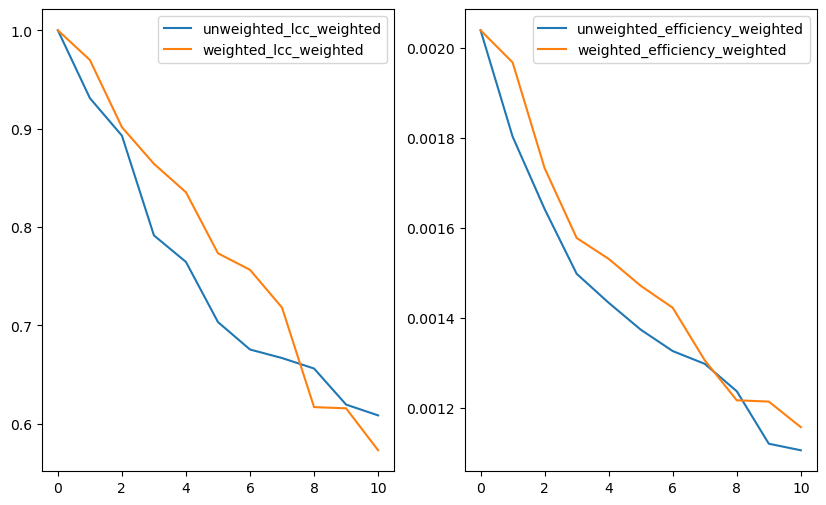

In [92]:
# initialise plot
fig, axes = plt.subplots(1, 2, figsize = (10, 6))

# set color map
color_palette = 'Accent'

# plot the LCC figure
bet_remove_df.plot(
    y = ['unweighted_lcc_weighted', 'weighted_lcc_weighted'],
    ax = axes[0]
)

# plot the efficiency figure
bet_remove_df.plot(
    y = ['unweighted_efficiency_weighted', 'weighted_efficiency_weighted'],
    ax = axes[1]
)

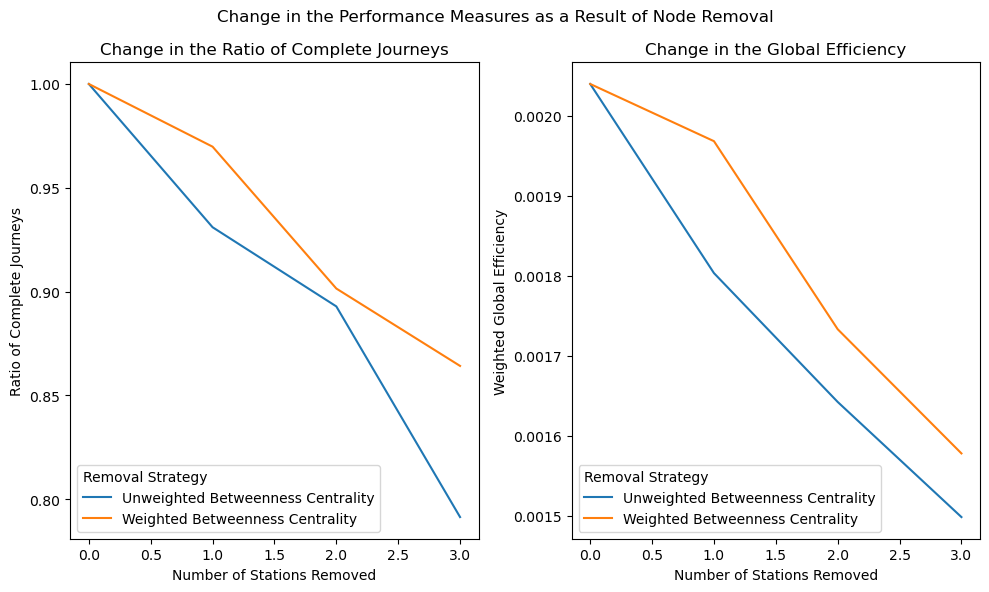

In [99]:
#use only the first three
bet_remove_df_plot = bet_remove_df[:4].copy()

# initialise plot
fig, axes = plt.subplots(1, 2, figsize = (10, 6))

# set color map
color_palette = 'Accent'

# plot the LCC figure
bet_remove_df_plot.plot(
    y = ['unweighted_lcc_weighted', 'weighted_lcc_weighted'],
    ax = axes[0],
    label = ['Unweighted Betweenness Centrality', 'Weighted Betweenness Centrality']
)

axes[0].set_xlabel('Number of Stations Removed')
axes[0].set_ylabel('Ratio of Complete Journeys')
axes[0].set_title('Change in the Ratio of Complete Journeys')

# plot the efficiency figure
bet_remove_df_plot.plot(
    y = ['unweighted_efficiency_weighted', 'weighted_efficiency_weighted'],
    ax = axes[1],
    label = ['Unweighted Betweenness Centrality', 'Weighted Betweenness Centrality']
)

# set labels
axes[1].set_xlabel('Number of Stations Removed')
axes[1].set_ylabel('Weighted Global Efficiency')
axes[1].set_title('Change in the Global Efficiency')

# set legend

for ax in axes:
    ax.legend(
        title = 'Removal Strategy',
        alignment = 'left',
        loc = 'lower left', bbox_to_anchor = (0, 0)
    )

plt.suptitle('Change in the Performance Measures as a Result of Node Removal')

plt.tight_layout()

plt.savefig('documents/img/weighted_node_removal_measures.png', bbox_inches = 'tight')